# Logistic Regression Modeling

In [98]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE

## Load Data

In [99]:
data_full = pd.read_csv("../data/processed/full_all_day_ahead.csv")
cols_1da = [c for c in data_full.columns if c.endswith("_1") or c == "Abnormal"]
data_1da = data_full[cols_1da]
data_1da = data_1da.dropna()
data_1da_reduced = data_1da.drop(columns="RR_1")
X = data_1da_reduced.drop(columns="Abnormal")
y = data_1da_reduced.Abnormal

## Data Splitting and Resampling

In [100]:
np.random.seed(500)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)
class_bal = pd.concat([pd.Series(y_test).value_counts(), pd.Series(y_train).value_counts()], axis=1)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

class_bal = pd.concat([class_bal, pd.Series(y_train).value_counts()], axis=1)
class_bal.columns = ["Test", "Train (Pre-SMOTE)", "Train (Post-SMOTE)"]
class_bal


,Test,Train (Pre-SMOTE),Train (Post-SMOTE)
Abnormal,,,
0.0,756,1764,1764
1.0,11,24,1764


## Full Model

In [101]:
for idx_train, idx_test in StratifiedKFold(n_splits=5).split(X_train, y_train):
  mod_full = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty=None, max_iter=10000))
  ])
  mod_full.fit(X_train.iloc[idx_train], y_train[idx_train])
  pred_probs = mod_full.predict_proba(X_train.iloc[idx_test])[:,1]

  thres = [i/100 for i in range(101)]
  opt_thres = -1
  max_f2 = -1
  for t in thres:
    pred_y = [0 if p < t else 1 for p in pred_probs]
    prec, rec, f2, _ = precision_recall_fscore_support(y_train[idx_test], pred_y, beta=2, average="binary", zero_division=0)
    if f2 > max_f2: 
      max_f2 = f2
      opt_thres = t
    
  
  print(f"Optimal threshold: {opt_thres} F2: {max_f2}")

Optimal threshold: 0.23 F2: 0.9121976866456362
Optimal threshold: 0.19 F2: 0.9029227557411273
Optimal threshold: 0.25 F2: 0.9071618037135278
Optimal threshold: 0.2 F2: 0.9012987012987013
Optimal threshold: 0.1 F2: 0.891492613346918


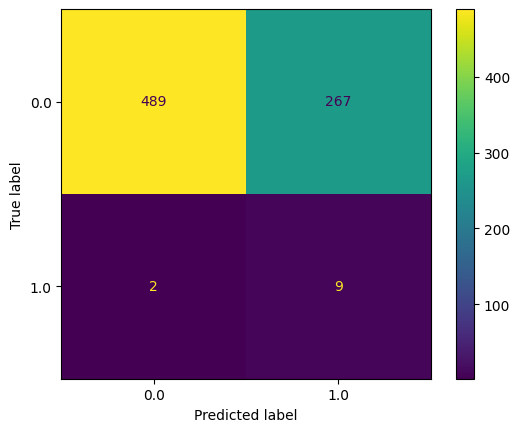

In [102]:
mod_full = Pipeline([
  ("scaler", StandardScaler()),
  ("clf", LogisticRegression(penalty=None, max_iter=10000))
])
mod_full.fit(X_train, y_train)
pred_probs = mod_full.predict_proba(X_test)[:,1]
pred_y = [0 if p < 0.23 else 1 for p in pred_probs]
ConfusionMatrixDisplay.from_predictions(y_test, pred_y)


In [103]:
print(f"Precision: {9/(9+267)}")
print(classification_report(y_test, pred_y, labels=[1]))

Precision: 0.03260869565217391
              precision    recall  f1-score   support

           1       0.03      0.82      0.06        11

   micro avg       0.03      0.82      0.06        11
   macro avg       0.03      0.82      0.06        11
weighted avg       0.03      0.82      0.06        11

